In [1]:
# %%
import os
import sys

from matplotlib import animation
sys.path.append("/home/mbortkie/repos/crl_subgoal/src")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
# %%
import functools
import os
import distrax


import jax
import jax.numpy as jnp
from jax import random
from typing import Tuple, Dict, Any
from dataclasses import dataclass
import chex
from flax import struct
from absl import app, flags
from ml_collections import config_flags
from impls.agents import agents
from config import SRC_ROOT_DIR
from envs.block_moving_env import *
from train import *
from impls.utils.checkpoints import restore_agent, save_agent
from config import Config, ExpConfig
from envs import legal_envs
import matplotlib.pyplot as plt
from impls.utils.networks import GCDiscreteActor
import copy
import numpy as np
import IPython.display as display




In [2]:
def display_gif(env, timesteps, idx):
    grid_size = timesteps.grid.shape[-2:]
    fig, ax = plt.subplots(figsize=grid_size)

    animate = functools.partial(env.animate, ax, jax.tree_util.tree_map(lambda x: x[:,idx:].swapaxes(1, 0), timesteps), img_prefix=os.path.join(ROOT_DIR, 'assets'))

    # Create animation
    anim = animation.FuncAnimation(fig, animate, frames=EPISODE_LENGTH, interval=80, repeat=False)

    # Save as GIF
    gif_path = f"/tmp/block_moving_epoch.gif"
    anim.save(gif_path, writer='pillow')
    plt.close()


    # Visualize the GIF in the notebook
    display.display(display.Image(filename=gif_path))


In [3]:
# %%
RANGE_GENERALIZATION = [1,2,3,4,5,6,7,9,11]
EPISODE_LENGTH = 100
NUM_ENVS = 1024
CHECKPOINT = 50
RUN_NAME = f"DQN{CHECKPOINT}_investigation"
# MODEL_PATH = "/home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044157/runs/dqn_1.38_3_grid_4_ep_len__filter_quarter"
MODEL_PATH = "/home/mbortkie/repos/crl_subgoal/experiments/many_boxes_crl_mc_grid_6_20251013_030052/runs/crl_long_diff_parametrization_phi_te_-1.1_grid_6_boxes_2"
EPOCHS = 51
EVAL_EVERY = 10
FIGURES_PATH = f"/home/mbortkie/repos/crl_subgoal/notebooks/figures/{RUN_NAME}"
GIF_PATH = f"{FIGURES_PATH}/gifs"
os.makedirs(FIGURES_PATH, exist_ok=True)
# os.makedirs(GIF_PATH, exist_ok=True)


In [4]:
# %%
config = Config(
    exp=ExpConfig(seed=0, name="test"),
    env=BoxPushingConfig(
        grid_size=4,
        number_of_boxes_min=1,
        number_of_boxes_max=1,
        number_of_moving_boxes_max=1
    )
)

# %%
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))
partial_flatten = functools.partial(flatten_batch, get_next_obs=config.agent.use_next_obs)
jitted_flatten_batch = jax.jit(jax.vmap(partial_flatten, in_axes=(None, 0, 0)), static_argnums=(0,))
dummy_timestep = env.get_dummy_timestep(key)


In [5]:
replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.agent.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

example_batch = {
    "observations": dummy_timestep.grid.reshape(1, -1),  # Add batch dimension
    "next_observations": dummy_timestep.grid.reshape(1, -1),
    "actions": jnp.ones((1,), dtype=jnp.int8)
    * (env._env.action_space - 1),  # it should be the maximal value of action space
    "rewards": jnp.ones((1,), dtype=jnp.int8),
    "masks": jnp.ones((1,), dtype=jnp.int8),
    "value_goals": dummy_timestep.grid.reshape(1, -1),
    "actor_goals": dummy_timestep.grid.reshape(1, -1),
}

# %%
agent, config = restore_agent(example_batch, MODEL_PATH, CHECKPOINT)


Restored from /home/mbortkie/repos/crl_subgoal/experiments/many_boxes_crl_mc_grid_6_20251013_030052/runs/crl_long_diff_parametrization_phi_te_-1.1_grid_6_boxes_2/params_50.pkl


In [6]:
# Create env once again with correct config and collect data
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)


In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_state(state):
    img_prefix="/home/mbortkie/repos/crl_subgoal/assets"
    fig, ax = plt.subplots(figsize=(5, 5))
    grid_state = state

    imgs = {
        int(GridStatesEnum.EMPTY): "floor.png",
        int(GridStatesEnum.BOX): "box.png",
        int(GridStatesEnum.TARGET): "box_target.png",
        int(GridStatesEnum.AGENT): "agent.png",
        int(GridStatesEnum.AGENT_CARRYING_BOX): "agent_carrying_box.png",
        int(GridStatesEnum.AGENT_ON_BOX): "agent_on_box.png",
        int(GridStatesEnum.AGENT_ON_TARGET): "agent_on_target.png",
        int(GridStatesEnum.AGENT_ON_TARGET_CARRYING_BOX): "agent_on_target_carrying_box.png",
        int(GridStatesEnum.AGENT_ON_TARGET_WITH_BOX): "agent_on_target_with_box.png",
        int(GridStatesEnum.AGENT_ON_TARGET_WITH_BOX_CARRYING_BOX): "agent_on_target_with_box_carrying_box.png",
        int(GridStatesEnum.BOX_ON_TARGET): "box_on_target.png",
        int(GridStatesEnum.AGENT_ON_BOX_CARRYING_BOX): "agent_on_box_carrying_box.png",
    }

    rows, cols = grid_state.shape[0], grid_state.shape[1]

    # Plot grid: col -> x axis, row -> y axis
    for row in range(rows):
        for col in range(cols):
            img_name = imgs[int(grid_state[row, col])]
            img_path = os.path.join(img_prefix, img_name)
            img = mpimg.imread(img_path)
            # left, right, bottom, top = col, col+1, row, row+1
            ax.imshow(img, extent=[col, col + 1, row, row + 1])

    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_aspect("equal")
    ax.invert_yaxis()  # keep (0,0) at top-left like array indexing; remove if you prefer origin at bottom-left
    plt.show()


In [11]:
def play_game(env, key: jax.Array):
    """Interactive game loop using input() for controls."""

    # Initialize the environment
    state, _ = env.reset(key)
    done = False
    info = {}
    total_reward = 0
    reward = 0

    print("=== Box Pushing Game ===")
    print("Controls: w(up), s(down), a(left), d(right), e(pickup), r(drop)")
    print("Goal: Move boxes to target cells (marked with 'T')")
    print("Press 'q' to quit\n")

    while True:
        # Display current state
        display_state(state.grid)
        no_targets = remove_targets(state.grid)
        print(no_targets)
        print(f"Steps: {state.steps}, Return: {total_reward}, Reward: {reward}")
        print(f"Info: {info}, Done: {done}")


        grid=remove_targets(state.grid)
        goal=remove_targets(state.goal)
        all_actions = jnp.tile(jnp.arange(6), (1, 1))  # B x 6
        qs = jax.lax.stop_gradient(
            jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(jnp.expand_dims(grid.flatten(), 0), jnp.expand_dims(goal.flatten(), 0), all_actions)
        )  # 6 x 2 x B
        qs = qs.mean(axis=1)  # 6 x B
        qs = jnp.log(qs)
        best = int(jnp.argmax(qs[:, 0]))
        print("Q-values:")
        for i, action_name in enumerate(["Up", "Down", "Left", "Right", "Pickup", "Drop"]):
            star = "*" if i == best else " "
            print(f"  {action_name}{star}: {qs[i,0]:.2f}")


        # Get user input
        action = None
        while action is None:
            try:
                user_input = input("Enter action (w/s/a/d/e/r/q/g): ").lower().strip()
                if user_input == "w":
                    action = 0  # Up
                elif user_input == "s":
                    action = 1  # Down
                elif user_input == "a":
                    action = 2  # Left
                elif user_input == "d":
                    action = 3  # Right
                elif user_input == "e":
                    action = 4  # Pickup
                elif user_input == "r":
                    action = 5  # Drop
                elif user_input == "q":
                    print("Game ended by user.")
                    return
                elif user_input == "g":
                    print("Game restarted by user.")
                    action = "restart"
                else:
                    print("Invalid input. Use w/s/a/d/e/r/q/g")
            except (EOFError, KeyboardInterrupt):
                print("\nGame ended by user.")
                return

        # Take action
        if action == "restart":
            state, info = env.reset(state.key)
        else:
            state, reward, done, info = env.step(state, action)
            total_reward += reward

=== Box Pushing Game ===
Controls: w(up), s(down), a(left), d(right), e(pickup), r(drop)
Goal: Move boxes to target cells (marked with 'T')
Press 'q' to quit



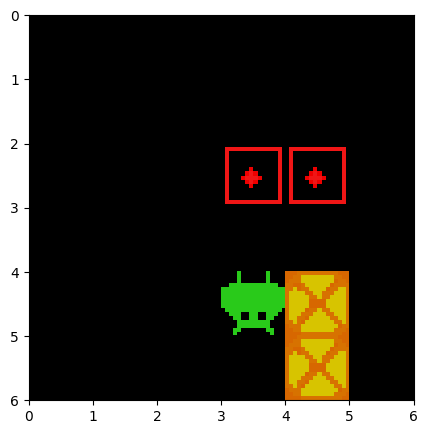

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 3 1 0]
 [0 0 0 0 1 0]]
Steps: 0, Return: 0, Reward: 0
Info: {}, Done: False
Q-values:
  Up : -8.30
  Down : -8.82
  Left : -14.99
  Right*: -5.01
  Pickup : -8.06
  Drop : -7.93


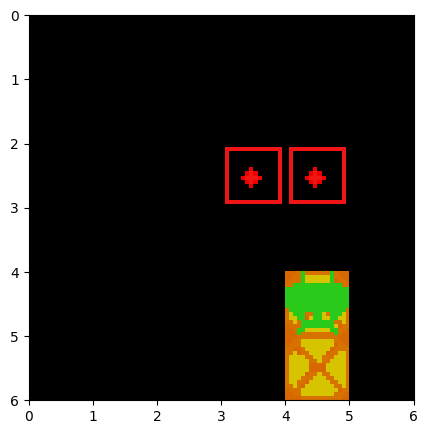

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 5 0]
 [0 0 0 0 1 0]]
Steps: 1, Return: 0.0, Reward: 0.0
Info: {'boxes_on_target': Array(0, dtype=int32), 'truncated': Array(False, dtype=bool)}, Done: False
Q-values:
  Up : -10.82
  Down : -5.78
  Left : -7.53
  Right : -6.29
  Pickup*: -5.00
  Drop : -5.65


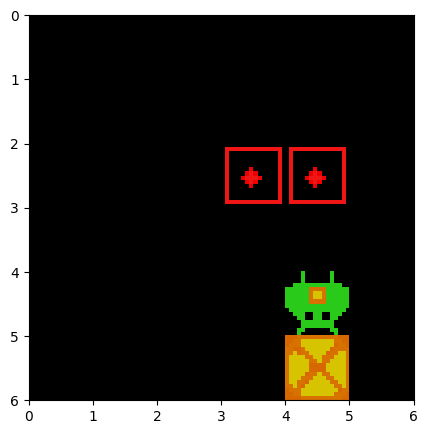

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 4 0]
 [0 0 0 0 1 0]]
Steps: 2, Return: 0.0, Reward: 0.0
Info: {'boxes_on_target': Array(0, dtype=int32), 'truncated': Array(False, dtype=bool, weak_type=True)}, Done: False
Q-values:
  Up*: -4.24
  Down : -8.12
  Left : -5.76
  Right : -6.61
  Pickup : -5.40
  Drop : -11.39


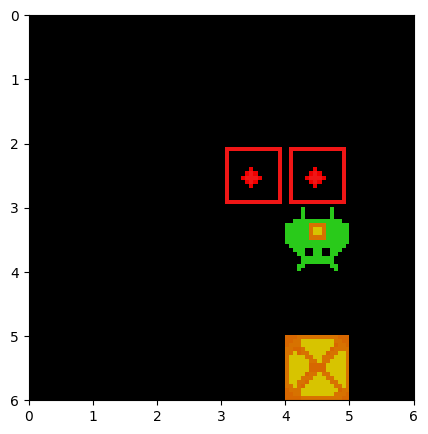

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 4 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]]
Steps: 3, Return: 0.0, Reward: 0.0
Info: {'boxes_on_target': Array(0, dtype=int32), 'truncated': Array(False, dtype=bool, weak_type=True)}, Done: False
Q-values:
  Up*: -4.41
  Down : -8.04
  Left : -5.35
  Right : -7.05
  Pickup : -5.14
  Drop : -6.86


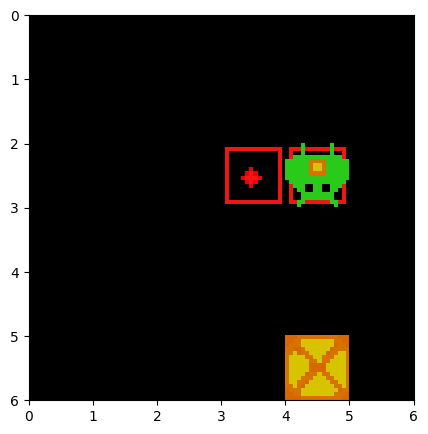

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 4 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]]
Steps: 4, Return: 0.0, Reward: 0.0
Info: {'boxes_on_target': Array(0, dtype=int32), 'truncated': Array(False, dtype=bool, weak_type=True)}, Done: False
Q-values:
  Up : -7.69
  Down : -11.49
  Left : -9.63
  Right : -11.55
  Pickup : -11.83
  Drop*: -2.93


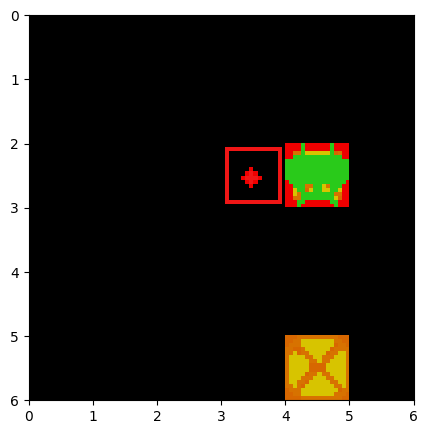

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 5 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]]
Steps: 5, Return: 0.0, Reward: 0.0
Info: {'boxes_on_target': Array(1, dtype=int32), 'truncated': Array(False, dtype=bool, weak_type=True)}, Done: False
Q-values:
  Up : -6.81
  Down*: -2.77
  Left : -5.59
  Right : -2.97
  Pickup : -11.82
  Drop : -8.31


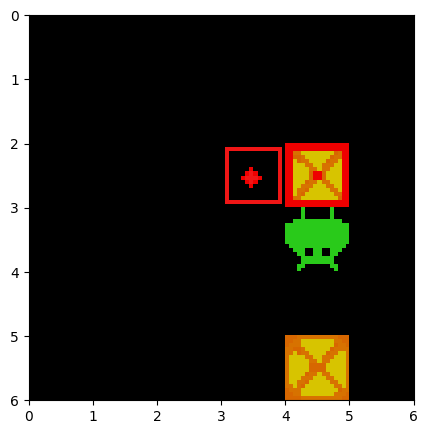

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]]
Steps: 6, Return: 0.0, Reward: 0.0
Info: {'boxes_on_target': Array(1, dtype=int32), 'truncated': Array(False, dtype=bool, weak_type=True)}, Done: False
Q-values:
  Up : -12.86
  Down*: -2.67
  Left : -7.13
  Right : -5.87
  Pickup : -6.93
  Drop : -6.99


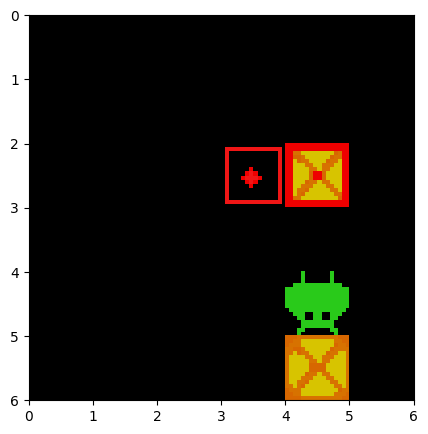

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 1 0]]
Steps: 7, Return: 0.0, Reward: 0.0
Info: {'boxes_on_target': Array(1, dtype=int32), 'truncated': Array(False, dtype=bool, weak_type=True)}, Done: False
Q-values:
  Up : -7.70
  Down : -2.60
  Left : -3.03
  Right : -2.80
  Pickup*: -2.51
  Drop : -2.58


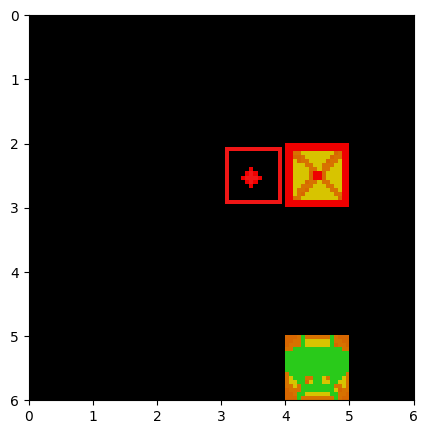

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 5 0]]
Steps: 8, Return: 0.0, Reward: 0.0
Info: {'boxes_on_target': Array(1, dtype=int32), 'truncated': Array(False, dtype=bool, weak_type=True)}, Done: False
Q-values:
  Up : -8.17
  Down : -2.63
  Left : -3.31
  Right : -3.74
  Pickup*: -2.23
  Drop : -2.73


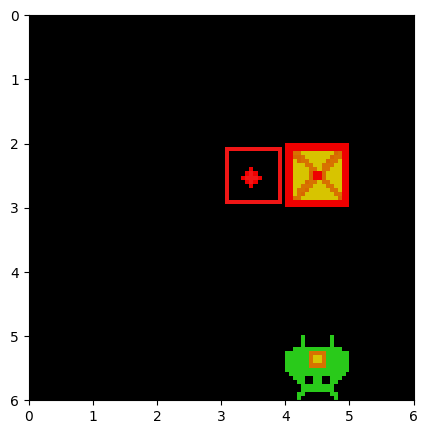

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 4 0]]
Steps: 9, Return: 0.0, Reward: 0.0
Info: {'boxes_on_target': Array(1, dtype=int32), 'truncated': Array(False, dtype=bool, weak_type=True)}, Done: False
Q-values:
  Up*: -2.20
  Down : -6.26
  Left : -2.38
  Right : -3.77
  Pickup : -2.39
  Drop : -9.30


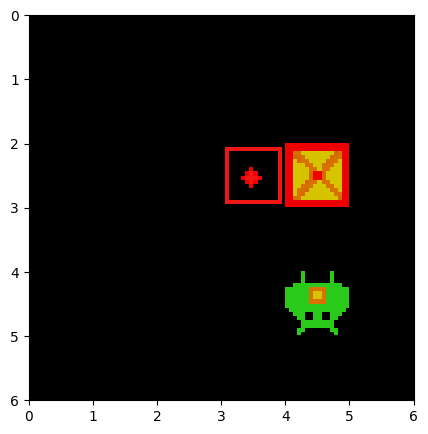

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 4 0]
 [0 0 0 0 0 0]]
Steps: 10, Return: 0.0, Reward: 0.0
Info: {'boxes_on_target': Array(1, dtype=int32), 'truncated': Array(False, dtype=bool, weak_type=True)}, Done: False
Q-values:
  Up : -3.22
  Down : -6.16
  Left*: -1.59
  Right : -3.85
  Pickup : -2.07
  Drop : -9.47
Game ended by user.


In [12]:
play_game(env, key)